## **Introduction**

Image Segmentation is a process of extracting pixel layers in an image. The layers are extracted as classes. This model provides detail information about an image.

Image segmentation is used in many applications like

*   Satellite Imaging
*   Medical Applications

This report uses Oxford-IIIT Pet Dataset that has image of 37 breeds with more than 200 images for each breed.

Layer of images as are labled as classes

Class 1: Pixel belongs to the image of the pet
Class 2: Pixels associated to the border of pet's image
Class 3: Other than the above


First of all the projet should be installed into location system from Tensorflow Github with the help pf pip install command.




In [1]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-u5qkco7l
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-u5qkco7l
  Created wheel for tensorflow-examples: filename=tensorflow_examples-6ae97eaf3dbd607ed3eccf18f7dc05d7a3b677e3_-py3-none-any.whl size=299717 sha256=fb586790cd129ab42f442d455401875b02ebe432a7458ef23e27b5c94008d779
  Stored in directory: /tmp/pip-ephem-wheel-cache-ekrupnfd/wheels/4e/f5/c2/bfe75b834c9028b2529023bf74541c46ead531b513a8010d21
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

Once it is installed now we can import tensorflow modules and components as given below

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Dataset from Oxford-IIIT Pets archive

An now we can download tensorflow dataset

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXZ90FY/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXZ90FY/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Image color values are normalized to [0, 1] range. The layer segmentation mask labels are marked as {1, 2, 3} and let us subtract each by 1 to get {0, 1, 2}

In [4]:
#python function to normalize and to subtract 1 from mask labels

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

Function to load image

In [5]:
# Function to load image
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128)) # TF image 
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128)) # Input mask
  # We have to normalize  by subtracting 1
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

So far we have used the Oxford-IIIT Dataset, it already provides the training and test splits, that we can reuse, or else we can also generate our own. To use the existing one we can do as follows-

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE) # loading image to trin set
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)   # Test set

### **Image Argumentation**

The technique to increase diversity in the training set by applying random transformation of an image like skewing, scaling and rotating etc is known as argumentation. The Keras preprocessing layers API allows developers to build Keras-native input processing pipelines. We can use Keras method to do so-

In [8]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Next course of activity is building input pipeline 

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

visualizing the image

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']
  #Ploting image
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

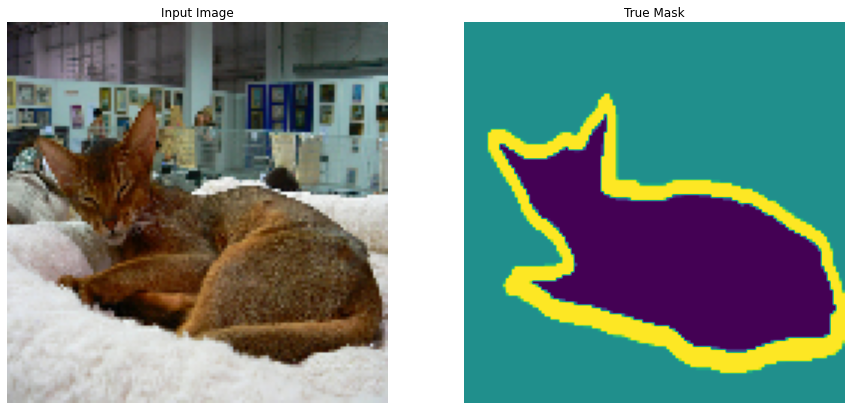

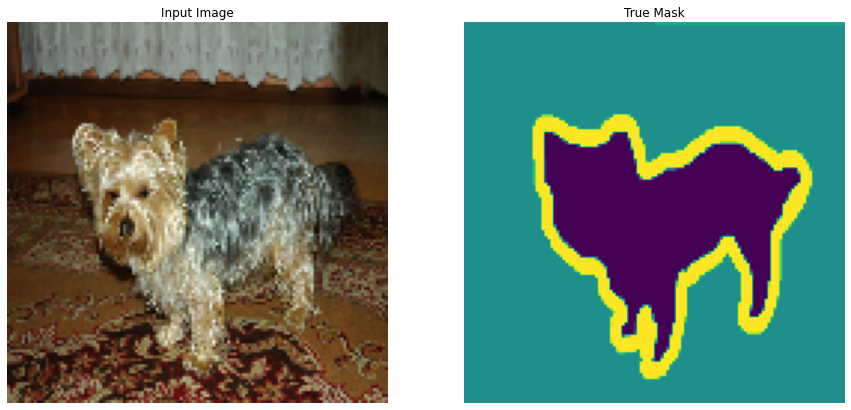

In [11]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# Modeling

 U-Net consists of an encoder (downsampler) and decoder (upsampler).. The model inculcates the image sizes and starts to struct the overall architecture through which our images will be passed.

 There are number of application models in Keras Application such as -

 DenseNet121, MobileNetV2, ResNet50V2, EfficientNetB5 etc

 We can use here **MobileNetV2**

But other above models can also be used



In [12]:
#base_model = tf.keras.applications.EfficientNetB5(input_shape=[128, 128, 3], include_top=False)
#base_model = tf.keras.applications.DenseNet121(input_shape=[128, 128, 3], include_top=False)

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


Decoding

In [13]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# **Train Model**

Let is train and compile 

In [14]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Plotting model

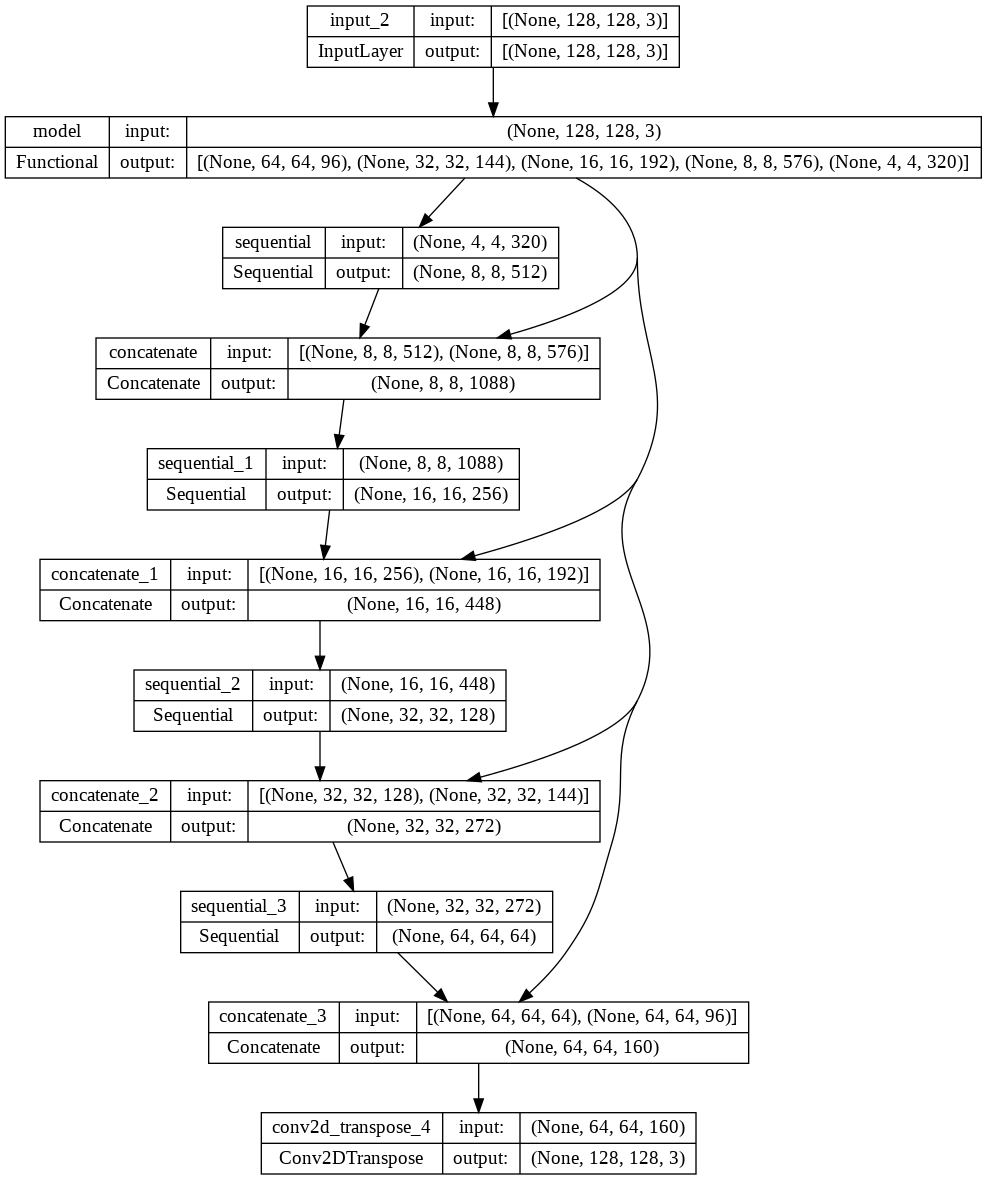

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

Function to identify Predictions before training

1/1 [==============================] - 10s 10s/step


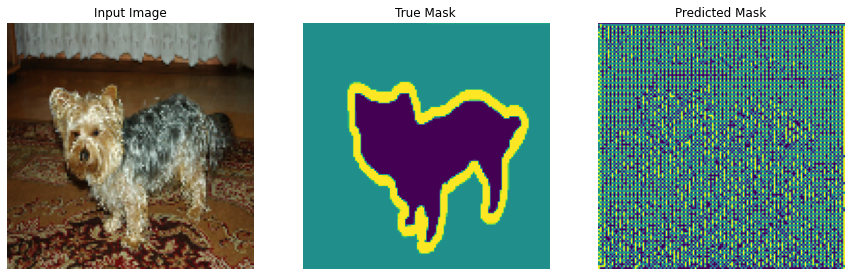

In [16]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

Prediction after epcho

In [17]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


1/1 [==============================] - 0s 43ms/step


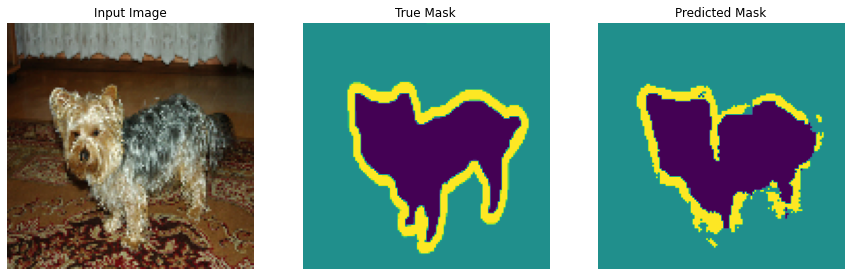


Sample Prediction after epoch 10

57/57 [==============================] - 11s 191ms/step - loss: 0.2285 - accuracy: 0.9020 - val_loss: 0.2608 - val_accuracy: 0.8946


In [18]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

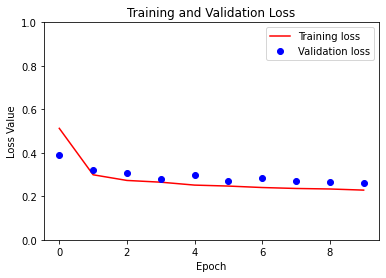

In [19]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Once again let us predict

2/2 [==============================] - 0s 62ms/step


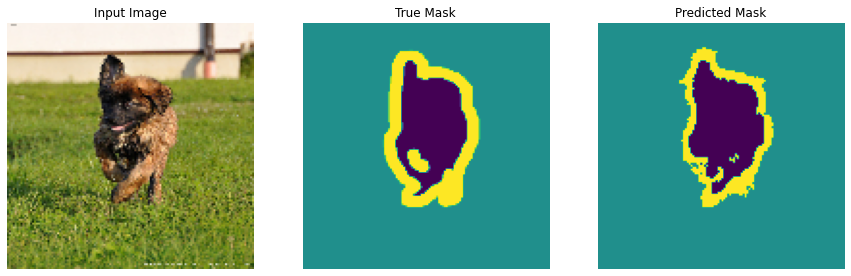

2/2 [==============================] - 0s 71ms/step


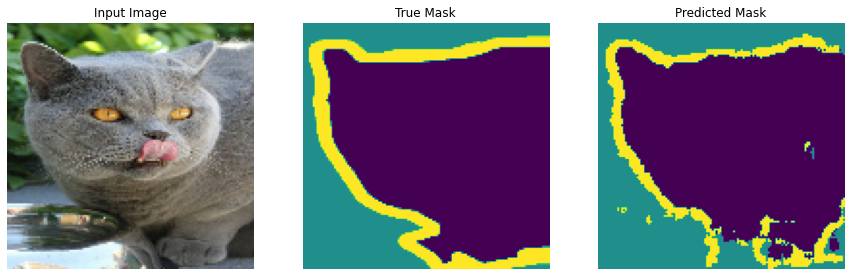

2/2 [==============================] - 0s 53ms/step


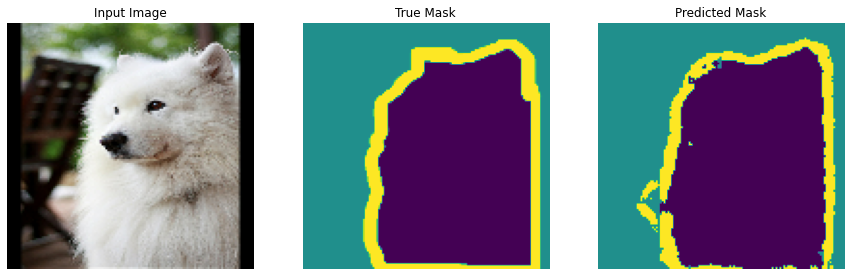

In [20]:
show_predictions(test_batches, 3)